Import Librerias

In [643]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import datetime as dt

Extraccion y Limpieza de Datos

In [644]:
bike_train = pd.read_excel('./bike_train.xlsx')
bike_test = pd.read_excel('./bike_test.xlsx')

In [645]:
bike_train.drop(columns=['dteday', 'instant', 'yr', 'mnth', 'hr', 'casual', 'registered'], axis=1, inplace=True)
#bike_train.set_index('dteday', inplace=True)

In [646]:
bike_test.drop(columns=['dteday', 'instant', 'yr', 'mnth', 'hr'], axis=1, inplace=True)
#bike_test.set_index('dteday', inplace=True)

In [647]:
bike_train.head()

,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,1,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,1,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [648]:
bike_test.head()

,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,2,0,0,0,1,0.52,0.5000,0.68,0.0896
1,2,0,0,0,1,0.50,0.4848,0.72,0.1045
2,2,0,0,0,1,0.50,0.4848,0.63,0.1343
3,2,0,0,0,1,0.52,0.5000,0.68,0.1940
4,2,0,0,0,1,0.56,0.5303,0.56,0.1642


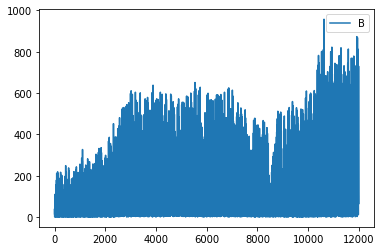

In [649]:
bike_train['cnt'].plot(legend=True)
plt.legend('Bike training')
plt.show()

Eliminar Outliers

In [650]:
# Se usa rango intercuartilico para mas precision
Q1 = np.percentile(bike_train['cnt'], 25,
                method='midpoint')

Q3 = np.percentile(bike_train['cnt'], 75,
                method='midpoint')
IQR = Q3 - Q1

# Upper bound
upper = np.where(bike_train['cnt'] >= (Q3 + 1.5 * IQR))
# Lower bound
lower = np.where(bike_train['cnt'] <= (Q1 - 1.5 * IQR))

bike_train.drop(upper[0], inplace=True)
bike_train.drop(lower[0], inplace=True)
bike_train.reset_index(drop=True, inplace=True)

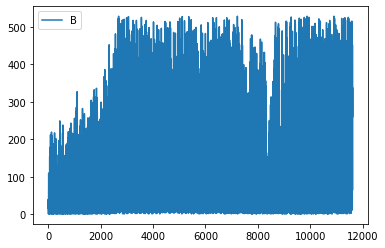

In [651]:
bike_train['cnt'].plot(legend=True)
plt.legend('Bike training')
plt.show()

Seleccion de Train para el modelo

In [652]:
bike_test.shape[0]

5380

In [653]:
# Con base al shape del test, elegimos para el train
train_df = bike_train[1:5381]

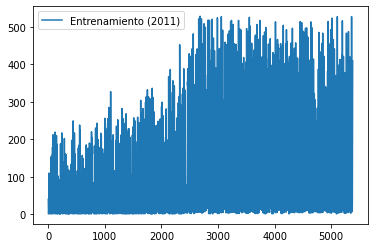

In [654]:
train_df['cnt'].plot(legend=True)
plt.legend(['Entrenamiento (2011)', 'Validación (2012)'])
plt.show()

Seleccion del Modelo (Arbol de Regresion)

In [655]:
# Como criterio de loss se eligio MSE, con una profundidad de 15 arboles y minimo 5 ramas
reg_tree = DecisionTreeRegressor(criterion='squared_error', max_depth=15, min_samples_leaf=5, random_state=40)
# Se entrena con los datos filtrados por la shape del test
reg_tree.fit(train_df.iloc[:, :-1],train_df.iloc[:, -1:])

DecisionTreeRegressor(max_depth=15, min_samples_leaf=5, random_state=40)

In [656]:
# Se predice sobre test, se calcula RMSE sobre la predicion y datos de training
pred = reg_tree.predict(bike_test)
rmse = np.sqrt(mean_squared_error(pred, train_df.iloc[:, -1:]))

In [657]:
rmse

174.4009172757859

In [658]:
pred_series = pd.Series(pred, name='cnt')
df = pd.DataFrame(pred_series)
test_df = pd.merge(bike_test, df, left_index=True, right_index=True)

In [659]:
train_df.shape[0] * 0.10

538.0

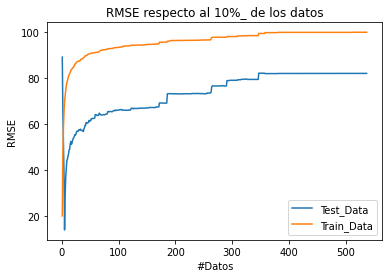

In [660]:
"""
Plot del RMSE con respecto a el numero minimo de instancias
""" 
fig = plt.figure()
ax0 = fig.add_subplot(111) 

RMSE_train = []
RMSE_test = []

for i in range(1,538):
    # Se asignan parametros, tal que i sea el numero de ramas por arbol
    regression_model = DecisionTreeRegressor(criterion="squared_error",min_samples_leaf=i)   
    # Se entrena
    regression_model.fit(train_df.iloc[:,:-1],train_df.iloc[:,-1:])
    # Se predice
    predicted_train = regression_model.predict(train_df.iloc[:,:-1])
    predicted_test = regression_model.predict(test_df.iloc[:,:-1])
    # Calculamos el RMSE y lo agregamos a las listas
    RMSE_train.append(np.sqrt(np.sum(((train_df.iloc[:,-1]-predicted_train)**2)/len(train_df.iloc[:,-1]))))
    RMSE_test.append(np.sqrt(np.sum(((test_df.iloc[:,-1]-predicted_test)**2)/len(test_df.iloc[:,-1]))))


# Se grafica
ax0.plot(range(1,538),RMSE_test,label='Test_Data')
ax0.plot(range(1,538),RMSE_train,label='Train_Data')
ax0.legend()
ax0.set_title('RMSE respecto al 10%_ de los datos')
ax0.set_xlabel('#Datos')
ax0.set_ylabel('RMSE')
plt.show()

Exportacion como CSV

In [663]:
df.rename(columns={'cnt': 'pred'}, inplace=True)
df.to_csv('./rupertsky.csv', index=False, header=True)